In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [242]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataset as dt
from keras.utils import to_categorical
from xtx_model import simple_model, simple_cnn, simple_mlp, get_weight_grad
from main import tf_score, score, model_score
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pickle
import copy
import pandas as pd
import warnings
import normlization as dt_norm
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error

## 1. load raw data

#### 1.1 load data

In [245]:
raw_data = dt.load_raw_data()

In [247]:
np.mean(raw_data[:, 60] ** 2)

0.5020568

In [142]:
def ema(x, n):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, x.shape[0]):
        y[i] = (n-1)/(n+1) * y[i-1] + 2/(n+1) * x[i]
    return y

In [251]:
askrate0 = raw_data[:, 0]
ema_askrate0 = ema(askrate0, 66)

y = raw_data[:, 60]
cum_y = np.cumsum(y)

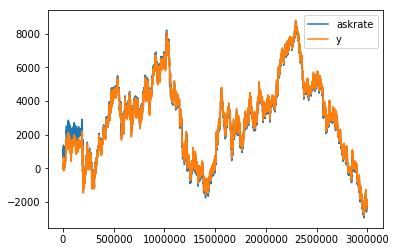

In [252]:
normed_askrate0 = (ema_askrate0 - np.mean(ema_askrate0)) * np.std(cum_y) / np.std(ema_askrate0) + np.mean(cum_y) 
plt.plot(normed_askrate0[110:], label='askrate')
plt.plot(cum_y, label='y')
plt.legend()
plt.show()

In [229]:
min_e = []
for i in range(24, 150):
    ema_askrate0 = ema(askrate0, i)
    normed_askrate0 = (ema_askrate0 - np.mean(ema_askrate0)) * np.std(cum_y) / np.std(ema_askrate0) + np.mean(cum_y) 
    e = 1e5
    for k in range(50, 200):
        e = np.minimum(e, np.mean(np.abs(normed_askrate0[k:] - cum_y[:-k])))
    min_e.append(e)

In [253]:
y = np.diff(cum_y)[500000:-110]
pred_y = np.diff(normed_askrate0)
pred_y = pred_y[500110:]
score(y, pred_y)

-0.7320184707641602

#### 1.2 plot raw data distribution

In [196]:
train_data = raw_data[:400000:10]
test_data = raw_data[-400000::10]

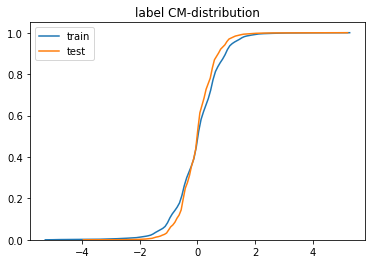

In [198]:
dt.train_test_plot(train_data[:,60], test_data[:,60], title='label CM-distribution')

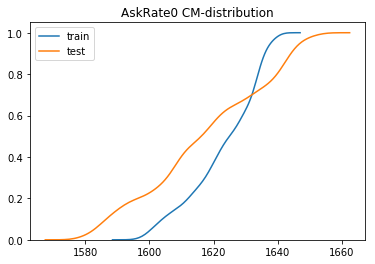

In [206]:
dt.train_test_plot(train_data[:, 0], test_data[:, 0], title='AskRate0 CM-distribution')

## 2. data pre-processing

#### 2.1 whitening

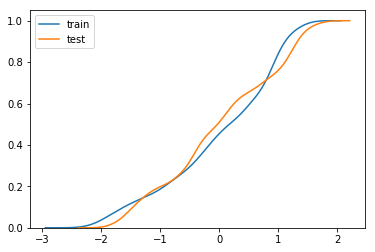

In [244]:
train_data = np.copy(raw_data[:400000:10, 0])
test_data = np.copy(raw_data[-400000::10, 0])

train_mean = np.mean(train_data)
train_std = np.std(train_data)
train_data = (train_data - train_mean) / train_std
test_mean = np.mean(test_data)
test_std = np.std(test_data)
test_data = (test_data - test_mean) / test_std

dt.train_test_plot(train_data, test_data)

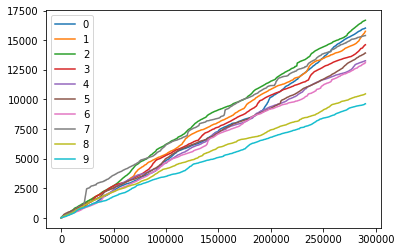

In [43]:
raw_diff = np.diff(raw_data[:2900001, 0]) != 0
raw_diff = np.cumsum(raw_diff)
for k in range(10):
    plt.plot(raw_diff[k*290000:(k+1)*290000] - raw_diff[k*290000], label='{}'.format(k))
plt.legend()
plt.show()

#### 2.1 sliding whitening

In [293]:
def get_data(window_size=60):
    _train = np.pad(raw_data[:400000], ((window_size-1, 0), (0,0)), 'edge')
    _test = np.pad(raw_data[-400000:], ((window_size-1, 0), (0,0)), 'edge')
    train_x, train_y = dt.data_sliding(_train, time_step=window_size)
    test_x, train_y = dt.data_sliding(_test, time_step=window_size)
    
    train_data = (train_x[:, -1] - np.mean(train_x, axis=1)) / (np.std(train_x, axis=1) + 1e-4)
    test_data = (test_x[:, -1] - np.mean(test_x, axis=1)) / (np.std(test_x, axis=1) + 1e-4)
    return train_data[::10, 0], test_data[::10, 0]

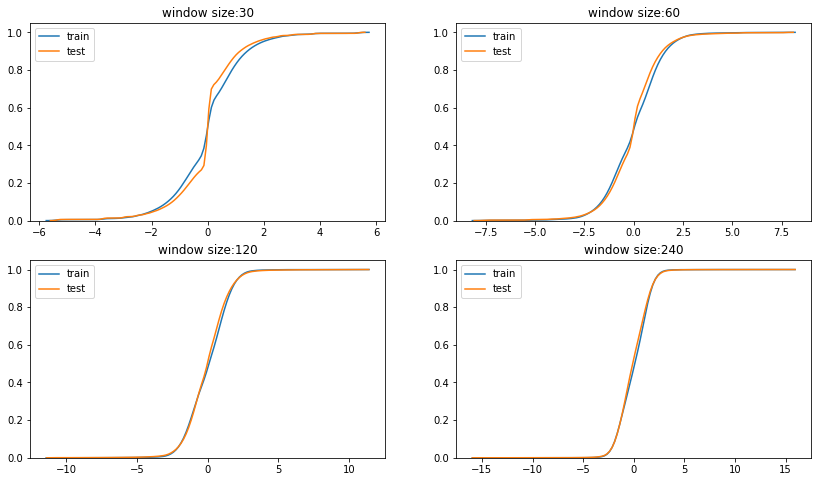

In [294]:
window_sizes = [30, 60, 120, 240]
plt.subplots(2, 2, figsize=(14,8))
for i, size in enumerate(window_sizes):
    axe = plt.subplot(2, 2, i+1)
    train_data, test_data = get_data(size)
    sns.kdeplot(train_data, cumulative=True, legend=True, ax=axe, label='train')
    sns.kdeplot(test_data, cumulative=True, legend=True, ax=axe, label='test')
    plt.title('window size:{}'.format(size))
plt.show()

#### 2.2 normlization

In [23]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=60, norm_window_size=15)

train:359992, val:59999, test:179997


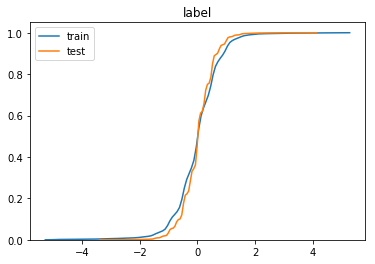

In [38]:
dt.train_test_plot(train_y[:40000], test_y[:40000], title='label')

# model

In [44]:
# callbacks
checkpoint = ModelCheckpoint('', monitor='val_loss', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=8, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, min_delta=1e-4, verbose=1)
train_callbacks = [earlystop, reduce_lr]

### lstm

In [256]:
# lstm
model = simple_model(regression=True)
model.compile(Adam(2e-4), loss=tf_score, metrics=['accuracy'])
model.fit(train_x, train_y, batch_size=128, epochs=10, validation_data=(val_x, val_y))

Train on 359992 samples, validate on 59999 samples
Epoch 1/10
359992/359992 [==============================] - 411s 1ms/step - loss: 1.3067 - acc: 0.1880 - val_loss: 1.0949 - val_acc: 0.2256
Epoch 2/10
359992/359992 [==============================] - 410s 1ms/step - loss: 1.0410 - acc: 0.1881 - val_loss: 0.9999 - val_acc: 0.2256
Epoch 3/10
359992/359992 [==============================] - 414s 1ms/step - loss: 1.0001 - acc: 0.1881 - val_loss: 0.9896 - val_acc: 0.2256
Epoch 4/10
359992/359992 [==============================] - 412s 1ms/step - loss: 0.9927 - acc: 0.1881 - val_loss: 0.9872 - val_acc: 0.2256
Epoch 5/10
359992/359992 [==============================] - 408s 1ms/step - loss: 0.9896 - acc: 0.1881 - val_loss: 0.9841 - val_acc: 0.2256
Epoch 6/10
359992/359992 [==============================] - 407s 1ms/step - loss: 0.9877 - acc: 0.1881 - val_loss: 0.9858 - val_acc: 0.2256
Epoch 7/10
359992/359992 [==============================] - 408s 1ms/step - loss: 0.9860 - acc: 0.1881 - val_

In [ ]:
# test
test_y_prob = model.predict(test_x, batch_size=128, verbose=1)
test_y_pred = np.argmax(test_y_pred, axis=1)
sns.distplot(test_y_pred, kde=False)

score(test_y*0.25 - 1.25, test_y_pred_*0.25 - 1.25)

### cnn

In [71]:
# cnn
model = simple_cnn()
model.compile(Adam(3e-4), loss=categorical_crossentropy, metrics=['accuracy'])
# model.summary()

### mlp

In [115]:
time_step = 15
(train_x, train_y), (val_x, val_y), (test_x, test_y) = dt.dataset_slide_norm(time_step=time_step, norm_window_size=10)

train:509997, val:60000, test:30000


In [121]:
# mlp
model = simple_mlp(time_step=time_step, regression=True)
loss = 'mse' #categorical_crossentropy
model.compile(Adam(2e-4), loss=tf_score, metrics=['accuracy'])
# model.summary()

In [122]:
history = model.fit(train_x, train_y, batch_size=128, epochs=20, validation_data=(val_x, val_y), callbacks=train_callbacks)
train_score, test_score = model_score(model, train_x, train_y, test_x, test_y)

Train on 509997 samples, validate on 60000 samples
Epoch 1/20
509997/509997 [==============================] - 27s 53us/step - loss: 1.0158 - acc: 0.2035 - val_loss: 0.9869 - val_acc: 0.2521
Epoch 2/20
509997/509997 [==============================] - 25s 49us/step - loss: 0.9924 - acc: 0.2040 - val_loss: 0.9857 - val_acc: 0.2521
Epoch 3/20
509997/509997 [==============================] - 25s 49us/step - loss: 0.9900 - acc: 0.2040 - val_loss: 0.9831 - val_acc: 0.2521
Epoch 4/20
509997/509997 [==============================] - 25s 49us/step - loss: 0.9882 - acc: 0.2040 - val_loss: 0.9835 - val_acc: 0.2521
Epoch 5/20
509997/509997 [==============================] - 25s 49us/step - loss: 0.9867 - acc: 0.2040 - val_loss: 0.9827 - val_acc: 0.2521
Epoch 6/20
509997/509997 [==============================] - 25s 49us/step - loss: 0.9855 - acc: 0.2040 - val_loss: 0.9833 - val_acc: 0.2521
Epoch 7/20
509997/509997 [==============================] - 25s 49us/step - loss: 0.9846 - acc: 0.2040 - val_

In [254]:
model.save_weights('t15_w10.weights')

In [248]:
test_pred_y = model.predict(test_x, batch_size=128, verbose=1)

30000/30000 [==============================] - 0s 16us/step


In [250]:
mean_squared_error(test_y, test_pred_y)

0.38325295

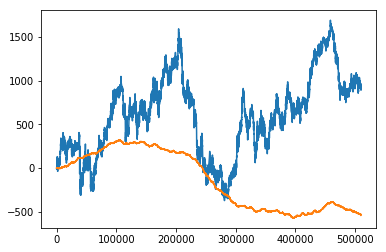

In [241]:
plt.plot(np.cumsum(train_y))
plt.plot(np.cumsum(train_pred_y))
plt.show()

In [12]:
weights = model.get_weights()

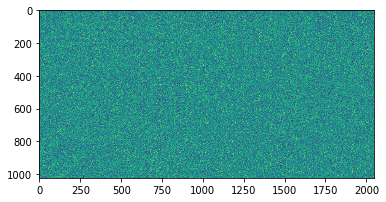

In [22]:
plt.imshow(weights[6])
plt.show()

In [19]:
train_score, test_score = model_score(model, train_x, train_y, test_x, test_y)

359992/359992 [==============================] - 11s 30us/step
train score: 0.02471
179997/179997 [==============================] - 5s 30us/step
test score: 0.01400


## hyper parameters search

In [ ]:
time_step = [5, 10, 20, 30, 60, 90, 120, 240, 360]
norm_window = [30, 60, 120, 360]
learning_rate = [2e-4, 3e-4, 5e-4, 8e-4, 1e-3]
